<a href="https://colab.research.google.com/github/alzuaz/Massive-Computing/blob/main/SecondPracticalWork.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Second Practical work

* Name Student 1: Javier Alzuaz Villegas
* NIA Student 1: 100496335
* Name Student 2: Enrique Velázquez Caballero
* NIA Student 2: 100496427
  
This is second practical work skeleton.

It is divided in 3 parts_

1.   Python module load section: load all the needed modules
2.   Google Drive access and mounting
3.   Host load data
4.   GPU load





## Module load section
We will install the pycuda module in the colaboratory environment, to combine python and CUDA in our code. Because pycuda is not available by default, this task can take a few minutes.

As well we load numpy and matplotlib modules.

In [ ]:
!pip install pycuda

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 31.9 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.8/98.8 kB 11.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 103.2/103.2 kB 11.7 MB/s eta 0:00:00
  Created wheel for pycuda: filename=pycuda-2025.1.2-cp312-cp312-linux_x86_64.whl size=659050 sha256=057d17ccf365e6c440fb322271f43ba5beca6f49054c730b1bc967af16fd0216
  Stored in directory: /root/.cache/pip/wheels/d5/36/f3/ac5f09d768cad3fa15d5a3449bdfe65c3de58e69d036c73228
Successfully built pycuda


In [ ]:
!pip install nibabel

We import the Python modules which we will use in the notebook (numpy, pycuda and time module)

In [ ]:
import  numpy  as  np
import  pycuda.autoinit
from    pycuda.compiler import SourceModule
import  pycuda.driver as  drv
import  pycuda.gpuarray as  gpuarray
from sys import getsizeof
import time
from os.path import join

In [ ]:
%matplotlib inline
from PIL import Image
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import cProfile

In [ ]:
import nibabel as nib

# Three-dimensional filtering

The objective of the practice is to implement a three-dimensional filtering of information (usually a 3-dimensional image coming from, for example, medical images) to which a preprocessing must be performed for further analysis.

Due to technical limitations, we will assume that the filtering function is a cube of 3x3 voxels (or three-dimensional pixel) and the image will have a maximum size of 1Gbyte (1024x1024x1024), although it will not necessarily be cubic.

The block size will be 8x8x8 (512 cores per block < 1024 which is the maximum number allowed on most GPUs).

## How to filter a voxel?
To filter a voxel we select the coordinates of the voxel we want to filter and the surrounding neighbors in the 3 dimensions (for a 3x3 filter the coefficient corresponding to the voxel to be filtered corresponds to the positions (1,1,1) of the filter mask).
The n selected neighbors are multiplied by the corresponding coefficients in the filter mask, around the selected voxel, and the products are summed, as in the case of 2-dimensional filters.

The result of this sum is the value assigned to the selected position of the resulting voxel.

## Cases at the edges
To calculate the filtered voxel at a position corresponding to one of the edges of the image, we replicate that layer, so that the data of the missing layer is equal to that of the layer to be filtered.
In the case of edges or corners, the value of the corresponding corner is replicated.

## Clapping
The resulting data will be an floating point 32bits data.

## Mount Google Drive and access grant
This part could be used to access to your Google Drive Data, **ONLY IF YOU ARE USING GOOGLE COLABORATORY**. Otherwise leave commented out.

For security and privacy reasons, this permission is temporally, and will be requested every time you restart the notebook.

Your Google Drive will be mounted in the "/content/drive" folder. The first Folder will be "My Drive".

You have to copy your images to a folder in the "My Drive" folder in your Google Drive.

To check your available files, use the cell indicated as "**List Files in Folder**"

In [ ]:
from google.colab import drive
drive.mount("/content/drive")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!ls /content/drive/My\ Drive

 1712087227101.jpg
'1st Assignment.gdoc'
'2ND ASSIGNMENT.gdoc'
 7599157941338_240531092144545.svg
'Assignment 1: Classification and Prediction.gdoc'
'Assignment 1: Classification and Prediction - Gráfico de columnas 1.gsheet'
'Assignment 2.gdoc'
 BOE-A-2024-27390.gdoc
 BOE-A-2024-27390.pdf
'Certification Financial Responsability Enrique Velazquez.pdf'
 CNN_2_best.py
'Colab Notebooks'
 DATABASES.PROJECT2.gdoc
'Documento sin título (1).gdoc'
'Documento sin título (2).gdoc'
'Documento sin título.gdoc'
'Enrique Velázquez Caballero.gsheet'
'EXPRESIÓN ORAL Y ESCRITA'
'FINAL PRESENTATION.gslides'
'FINAL PROJECT DISCUSSION.gslides'
'Hoja de cálculo sin título (1).gsheet'
'Hoja de cálculo sin título.gsheet'
 IMG_2244.JPG
'INTERVIEW SUMMARY ENTREPRENEURSHIP (1).docx'
'INTERVIEW SUMMARY ENTREPRENEURSHIP.docx'
'INTRODUCTION TO DATA SCIENCE'
 MASSIVE
'MIDTERM PRESENTATION.gslides'
'NBA - Excel 2023-04-30 19-09-37.mp4'
 OneDrive_2023-09-24.zip
'PARCIAL DE Ã_TICA.docx'
 Personal_informatio

## IMAGES DEFINITION

The follow MYDRIVE variable will be used to address where are stored the images files.

Please, change it to your correct location.

All the images should be refered to this directory.

In [ ]:
MYDRIVE = "/content/drive/My Drive"

We define a variable IMAGE which is constructed joining the "MYDRIVE" varible plus the final path to your image.

In [ ]:
IMAGE=join(MYDRIVE,'someones_epi.nii')

In [ ]:
print("Image to load: {0}".format(IMAGE))

Image to load: /content/drive/My Drive/someones_epi.nii


Loads an image in a numpy variable, and show.

In [ ]:
epi_img = nib.load(IMAGE)
epi_img_data = epi_img.get_fdata().astype(np.float32)
epi_img_data.shape

(53, 61, 33)

In [ ]:
epi_img_data_final = epi_img_data.T

In [ ]:
epi_img_data_final.shape

(33, 61, 53)

In [ ]:
epi_img_data.dtype

dtype('float32')

Text(0.5, 0.98, 'Center slices for EPI image')

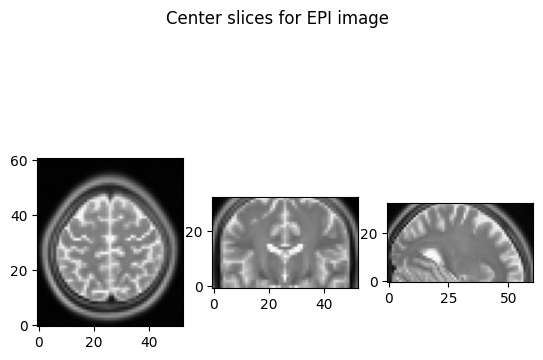

In [ ]:
import matplotlib.pyplot as plt

def show_slices(slices):

   """ Function to display row of image slices """

   fig, axes = plt.subplots(1, len(slices))

   for i, slice in enumerate(slices):

       axes[i].imshow(slice, cmap="gray", origin="lower")


slice_0 = epi_img_data_final[26, :, :]
slice_1 = epi_img_data_final[:, 30, :]
slice_2 = epi_img_data_final[:, :, 16]

show_slices([slice_0, slice_1, slice_2])
plt.suptitle("Center slices for EPI image")

## FILTERS DEFINITION

Here we defines our sample filter masks.

In [ ]:
#This is an identity filter: the resulting
filter1=np.zeros((3,3,3),dtype=np.float32)
filter1[1,1,1] =1.0

In [ ]:
#This is an edge detector filter in xy axis filter: the resulting
filter2=np.zeros((3,3,3),dtype=np.float32)
filter2[0,0,1] = -0.25
filter2[2,0,1] = -0.25
filter2[0,2,1] = 0.25
filter2[2,2,1] = 0.25

In [ ]:
#This is an edge detector filter in xz axis: the resulting
filter3=np.zeros((3,3,3),dtype=np.float32)
filter3[0,1,0] = -0.25
filter3[2,1,0] = -0.25
filter3[0,1,2] = 0.25
filter3[2,1,2] = 0.25

## FILTER KERNEL

Here you have to define your image_filter GPU kernel.

In [ ]:
kernel  =  SourceModule("""
__global__ void image_filter( float *src_image,      // Source GPU array (float32)
                              float *filter_mask,   // 3x3x3 filter mask (float32)
                              float *dst_image,     // Output GPU array (float32)
                              int NumVoxelsX,       // Image voxels in X
                              int NumVoxelsY,       // Image voxels in Y
                              int NumVoxelsZ )      // Image voxels in Z
{
    // Global voxel coordinates for this thread
    int idxX = blockIdx.x * blockDim.x + threadIdx.x;
    int idxY = blockIdx.y * blockDim.y + threadIdx.y;
    int idxZ = blockIdx.z * blockDim.z + threadIdx.z;

    // Base coordinates of this block in global memory
    int baseX = blockIdx.x * blockDim.x;
    int baseY = blockIdx.y * blockDim.y;
    int baseZ = blockIdx.z * blockDim.z;

    // Shared memory tile: 10x10x10 (8x8x8 block + 1-voxel halo on each side)
    // Order: [z][y][x]
    __shared__ float tile[10][10][10];

    // Shared memory for the 3x3x3 filter (27 coefficients)
    __shared__ float sFilter[27];

    // Linear thread id within the block
    int tid = threadIdx.z * blockDim.y * blockDim.x +
              threadIdx.y * blockDim.x +
              threadIdx.x;

    // First 27 threads load the filter into shared memory
    if (tid < 27) {
        sFilter[tid] = filter_mask[tid];
    }

    // Cooperative loading of the 10x10x10 tile into shared memory
    // Each thread loads one or more elements, using clamped global indices
    for (int lz = threadIdx.z; lz < 10; lz += blockDim.z) {
        int gz = baseZ + lz - 1;           // -1 because tile[1..8] corresponds to baseZ..baseZ+7
        if (gz < 0) gz = 0;
        else if (gz >= NumVoxelsZ) gz = NumVoxelsZ - 1;

        for (int ly = threadIdx.y; ly < 10; ly += blockDim.y) {
            int gy = baseY + ly - 1;
            if (gy < 0) gy = 0;
            else if (gy >= NumVoxelsY) gy = NumVoxelsY - 1;

            for (int lx = threadIdx.x; lx < 10; lx += blockDim.x) {
                int gx = baseX + lx - 1;
                if (gx < 0) gx = 0;
                else if (gx >= NumVoxelsX) gx = NumVoxelsX - 1;

                // Linear index in src_image, layout: [Y][X][Z]
                int index = gy * NumVoxelsX * NumVoxelsZ +
                            gx * NumVoxelsZ +
                            gz;

                tile[lz][ly][lx] = src_image[index];
            }
        }
    }

    // Ensure the whole tile and filter are loaded
    __syncthreads();

    // Only compute output for threads that map to a valid voxel
    if (idxX < NumVoxelsX && idxY < NumVoxelsY && idxZ < NumVoxelsZ) {
        // Local coordinates inside the shared tile (center region)
        int sx = threadIdx.x + 1;  // 1..8
        int sy = threadIdx.y + 1;
        int sz = threadIdx.z + 1;

        float acc = 0.0f;

        // 3x3x3 convolution using shared memory tile and shared filter
        for (int fz = 0; fz < 3; ++fz) {
            for (int fy = 0; fy < 3; ++fy) {
                for (int fx = 0; fx < 3; ++fx) {
                    float v = tile[sz + fz - 1][sy + fy - 1][sx + fx - 1];

                    int fIndex = (fz * 3 + fy) * 3 + fx;   // flatten (fz,fy,fx) -> [0..26]
                    float k = sFilter[fIndex];

                    acc += v * k;
                }
            }
        }

        // Write result to global memory (same layout: [Y][X][Z])
        int outIndex = idxY * NumVoxelsX * NumVoxelsZ +
                       idxX * NumVoxelsZ +
                       idxZ;

        dst_image[outIndex] = acc;
    }
}
""")


And import the kernel definition to python

In [ ]:
image_filter = kernel.get_function ('image_filter')

## SETUP EXPERIMENT

Recover the image shape, and select the two first items (rows and columns).

In [ ]:
image_shape=epi_img_data_final.shape

Set block size and grid size.

In [ ]:
block_s=8
block_size=(block_s,block_s,block_s)
grid_size=(int(np.ceil(image_shape[1]/block_s)),int(np.ceil(image_shape[0]/block_s)),int(np.ceil(image_shape[2]/block_s)))

Allocates the target image memory.

In [ ]:
result_image=np.zeros(epi_img_data_final.shape,dtype=np.float32)

### Select the filter mask, and upload to the GPU device.

In [ ]:
filter_mask=filter1.astype(np.float32)
filter_mask_gpu=gpuarray.to_gpu(filter_mask)

## Prepares the execution environment

In [ ]:
image_gpu=gpuarray.to_gpu(epi_img_data_final)

Allocate the temporal filtered memory layer, where will be store the filtered image.

In [ ]:
filtered_image_gpu = gpuarray.zeros(image_shape,np.float32)

Here defines the main block.
Walk through the layers. Copying the selected layer to temporal image_layer, upload the layer to the GPU and invokes the image_filter kernel.

In [ ]:
image_filter(                                        #invokes the kernel
    image_gpu,
    filter_mask_gpu,
    filtered_image_gpu,
    np.int32(image_shape[1]),
    np.int32(image_shape[0]),
    np.int32(image_shape[2]),
    block=block_size,
    grid=grid_size
  )

In [ ]:
filtered_image=filtered_image_gpu.get() #Download from the GPU the filtered image

In [ ]:
%%timeit -r 10 -n 10 -o
image_filter(                                        #invokes the kernel
    image_gpu,
    filter_mask_gpu,
    filtered_image_gpu,
    np.int32(image_shape[1]),
    np.int32(image_shape[0]),
    np.int32(image_shape[2]),
    block=block_size,
    grid=grid_size
  )

16.1 µs ± 4.81 µs per loop (mean ± std. dev. of 10 runs, 10 loops each)


<TimeitResult : 16.1 µs ± 4.81 µs per loop (mean ± std. dev. of 10 runs, 10 loops each)>

### The next lines is only valid for the original code, in order to check if the image was readed correct

In [ ]:
np.allclose(filtered_image,epi_img_data_final)

True

*NOTE* The follow code fetch from the stack the exectution statistics produced by the magic metacommand %%timeit and stores it in a python variable.

# Show results


Text(0.5, 0.98, 'Center slices for EPI image')

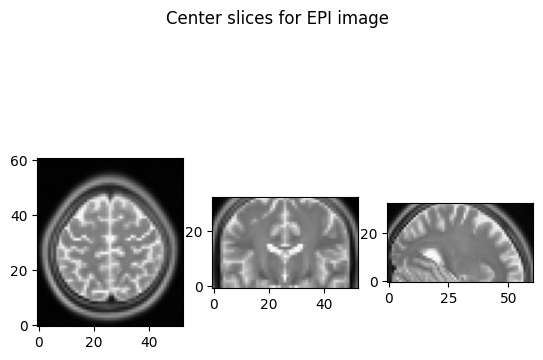

In [ ]:
slice_0 = filtered_image[26, :, :]
slice_1 = filtered_image[:, 30, :]
slice_2 = filtered_image[:, :, 16]

show_slices([slice_0, slice_1, slice_2])
plt.suptitle("Center slices for EPI image")

In [ ]:
statistics = _
print("Best execution time: {}".format(statistics.best))
print("Worst execution time: {}".format(statistics.worst))
print("Mean execution time: {mean} ({stdev} std dev)".format(mean=statistics.average,stdev=statistics.stdev))

Best execution time: 1.3125099940225482e-05
Worst execution time: 2.906600002461346e-05
Mean execution time: 1.6077260015663343e-05 (4.805301170745339e-06 std dev)


Now we are going to create a function that runs all this for a given kernel so we can also test the other examples:

In [ ]:
import time
import pycuda.autoinit
import pycuda.driver as cuda

def run_filter_gpu(filter_mask_np):
    """
    Runs the 3D filter on the GPU with the given 3x3x3 filter mask.
    Returns (filtered_image_cpu, duration_seconds).
    """
    # Make sure mask is float32
    filter_mask_np = filter_mask_np.astype(np.float32)

    # Upload filter to GPU
    filter_mask_gpu = gpuarray.to_gpu(filter_mask_np)

    # Allocate output buffer on GPU
    filtered_image_gpu = gpuarray.zeros(image_shape, np.float32)

    # Time the kernel (simple wall clock timing)
    t0 = time.perf_counter()
    image_filter(
        image_gpu,
        filter_mask_gpu,
        filtered_image_gpu,
        np.int32(image_shape[1]),  # NumVoxelsX
        np.int32(image_shape[0]),  # NumVoxelsY
        np.int32(image_shape[2]),  # NumVoxelsZ
        block=block_size,
        grid=grid_size
    )
    cuda.Context.synchronize()
    t1 = time.perf_counter()

    duration = t1 - t0

    # Download result to CPU
    filtered_image_cpu = filtered_image_gpu.get()

    return filtered_image_cpu, duration


SECOND KERNEL (edge detector filter in xy axis)

[GPU Edge XY] Duration: 0.000158 s


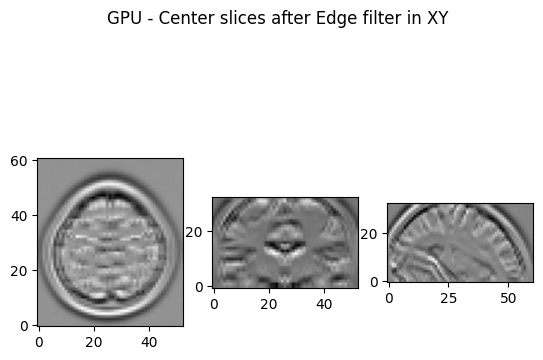

In [ ]:
# Edge XY filter
filtered_xy, t_xy = run_filter_gpu(filter2)
print(f"[GPU Edge XY] Duration: {t_xy:.6f} s")

slice_0 = filtered_xy[min(26, image_shape[0]-1), :, :]
slice_1 = filtered_xy[:, min(30, image_shape[1]-1), :]
slice_2 = filtered_xy[:, :, min(16, image_shape[2]-1)]
show_slices([slice_0, slice_1, slice_2])
plt.suptitle("GPU - Center slices after Edge filter in XY")
plt.show()

In [ ]:
%timeit -r 10 -n 10 -o run_filter_gpu(filter2)
statistics = _
print("Best execution time: {}".format(statistics.best))
print("Worst execution time: {}".format(statistics.worst))
print("Mean execution time: {mean} ({stdev} std dev)".format(mean=statistics.average,stdev=statistics.stdev))

404 µs ± 102 µs per loop (mean ± std. dev. of 10 runs, 10 loops each)
Best execution time: 1.3918800050305435e-05
Worst execution time: 3.184569995937636e-05
Mean execution time: 1.9327220015838976e-05 (6.699335765256261e-06 std dev)


THIRD KERNEL (edge detector filter in xz axis)

[GPU Edge XY] Duration: 0.000200 s


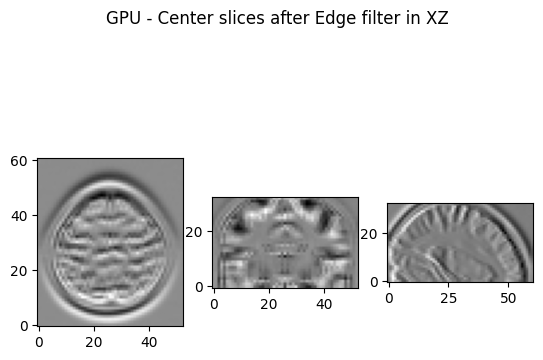

In [ ]:
# Edge XZ filter
filtered_xy, t_xy = run_filter_gpu(filter3)
print(f"[GPU Edge XY] Duration: {t_xy:.6f} s")

slice_0 = filtered_xy[min(26, image_shape[0]-1), :, :]
slice_1 = filtered_xy[:, min(30, image_shape[1]-1), :]
slice_2 = filtered_xy[:, :, min(16, image_shape[2]-1)]
show_slices([slice_0, slice_1, slice_2])
plt.suptitle("GPU - Center slices after Edge filter in XZ")
plt.show()

In [ ]:
%timeit -r 10 -n 10 -o run_filter_gpu(filter3)
statistics = _
print("Best execution time: {}".format(statistics.best))
print("Worst execution time: {}".format(statistics.worst))
print("Mean execution time: {mean} ({stdev} std dev)".format(mean=statistics.average,stdev=statistics.stdev))

391 µs ± 78.9 µs per loop (mean ± std. dev. of 10 runs, 10 loops each)
Best execution time: 1.3918800050305435e-05
Worst execution time: 3.184569995937636e-05
Mean execution time: 1.9327220015838976e-05 (6.699335765256261e-06 std dev)


# CONCLUSIONS

**Enrique's Conclusion**

This second practical work helped me understand how GPU parallelism can be applied to a real and computationally demanding problem: filtering a full 3D medical image using convolution. While the first assignment focused on CPU multiprocessing, this one showed me the difference in scale and strategy when working on a GPU, where thousands of threads operate simultaneously and memory access patterns become just as important as the computation itself.

One of the key lessons was how essential shared memory is for performance. Instead of allowing each thread to repeatedly fetch scattered values from slow global memory, we learned to load compact 3D tiles into shared memory, including the halo region needed for the 3×3×3 convolution. This tiling strategy drastically reduces memory traffic and is the main reason GPUs can accelerate this kind of task so much. It also made me realize that parallelism is not only about splitting the work, but about organizing data so the hardware can access it efficiently.

I also learned the importance of handling boundary conditions correctly, something that at first seems like a small implementation detail but is actually necessary for robust results. By clamping at the edges and replicating border voxels into the halo of each tile, we ensured that the filter behaved correctly across the entire volume and that no invalid memory accesses occurred. This reinforced how even small mistakes in indexing or memory access can break GPU kernels or generate incorrect images.

Overall, this project showed me what high-performance computing looks like when moving from CPU to GPU: careful memory design, synchronization, block and grid sizing, and an awareness of how each thread participates in a larger computation. Implementing the full 3D filter on the GPU helped me connect these concepts and understand how to structure a parallel algorithm that is both fast and correct, especially when working with large medical datasets.

In [ ]:
***